In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
with open('./train_data/train_data_output.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    record = []
    for row in reader:
        record.append(row)

## Data Analysis

In [3]:
df = pd.DataFrame(record[1:], columns=record[0])

number_combats = len(df[df["turn_num"] == "turn1"])
print(f"Number of Turns: {len(df)}\nNumber of Combats: {number_combats}")

total_num_pokemon = len(df["op_name"].unique())
print(f"Number of Pokemon: {total_num_pokemon}")

total_num_pokemon_win = len(df[df["win"]=="True"]["op_name"].unique())
print(f"Number of Pokemon never win: {total_num_pokemon - total_num_pokemon_win}")

pokemon_never_won = set(df["op_name"]).difference(set(df[df["win"]=="True"]["op_name"]))
print(f"Who are they? {pokemon_never_won}")

win_rate = (len(df.loc[(df['win'] == "True") & (df['turn_num'] == "turn1")])\
            / len(df[df["turn_num"] == "turn1"])) * 100
print(f"Win Rate: {win_rate:.2f}")

# How DataFrame looks like
df[:3]

Number of Turns: 387265
Number of Combats: 100226
Number of Pokemon: 151
Number of Pokemon never win: 3
Who are they? {'Mewtwo', 'Vaporeon', 'Lapras'}
Win Rate: 68.26


,turn_num,move_name,op_name,my_hp,op_hp,my_type1,my_type2,op_type1,op_type2,my_status,op_status,my_speed,op_speed,win
0,turn1,Slash,Metapod,138,110,Fire,Flying,Bug,,0,0,5005,1505,True
1,turn2,Slash,Metapod,132.0,68.0,Fire,Flying,Bug,,0,0,5005,1505,True
2,turn3,Flamethrower,Metapod,132.0,21.0,Fire,Flying,Bug,,0,0,5005,1505,True


In [4]:
type_counts = df['op_type1'].value_counts()
print("Number of min type: ", min(type_counts))
print("\nNumber of opponent type presented in data")
print(type_counts)

Number of min type:  3124

Number of opponent type presented in data
Water       68109
Normal      63360
Fire        38328
Poison      38299
Grass       26583
Bug         25651
Psychic     24487
Rock        24433
Ground      20114
Electric    20107
Fighting    15857
Dragon      11363
Ghost        7450
Ice          3124
Name: op_type1, dtype: int64


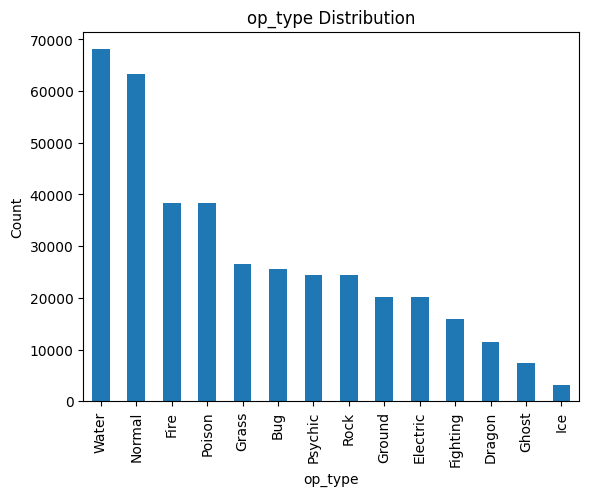

In [5]:
type_counts.plot(kind='bar')
plt.title('op_type Distribution')
plt.xlabel('op_type')
plt.ylabel('Count')
plt.show()

## Data processing

In [6]:
# Since there are too many pokemons with the type of "Water, Normal"
# this may affect the combat between Charizard and the pokemon with the type that not present much
# So: Take the # of type that presented the least, and sampling from every other types of pokemon with the same #

In [7]:
normalized_df = pd.DataFrame(columns=df.columns)
for t in df["op_type1"].unique():
    normalized_df = pd.concat([normalized_df, df[df["op_type1"]==t].sample(n=min(type_counts))])
normalized_df[:3]

,turn_num,move_name,op_name,my_hp,op_hp,my_type1,my_type2,op_type1,op_type2,my_status,op_status,my_speed,op_speed,win
202691,turn1,Flamethrower,Beedrill,138,125,Fire,Flying,Bug,Poison,0,0,5005,3755,True
372858,turn7,Dragon Rage,Venonat,104.0,80,Fire,Flying,Bug,Poison,4,0,5005,2255,True
153407,turn2,Dragon Rage,Beedrill,98,125,Fire,Flying,Bug,Poison,0,0,5005,3755,True


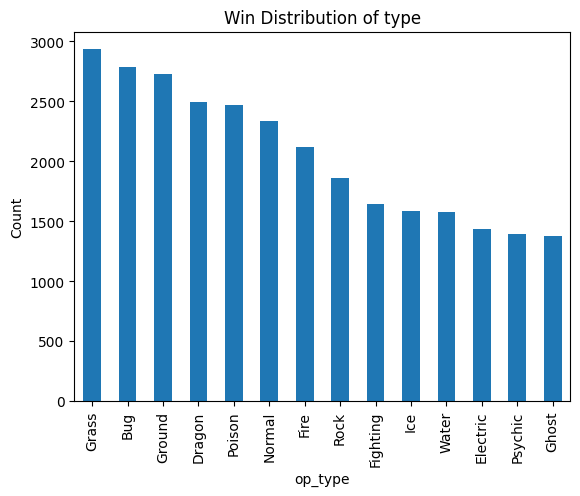

In [8]:
# Win Distribution
type_counts = normalized_df[normalized_df["win"]=="True"]["op_type1"].value_counts()
type_counts.plot(kind='bar')

plt.title('Win Distribution of type')
plt.xlabel('op_type')
plt.ylabel('Count')

plt.show()

In [9]:
# Focus train on the type of lower win_rate
win_percent = type_counts / min(normalized_df['op_type1'].value_counts())
win_percent_df = pd.DataFrame(list(win_percent.items()), columns = ["type", "percent"])

inverse_win_percent = 1 - type_counts / type_counts.sum()
inverse_win_percent_df = pd.DataFrame(list(inverse_win_percent.items()), columns = ["type", "percent"])

# Scale
scaler = MinMaxScaler(feature_range=(0.2, 1))

scaled_inverse_percent = scaler.fit_transform(inverse_win_percent_df[["percent"]])
scaled_inverse_percent = pd.concat([win_percent_df, \
                                    pd.DataFrame(scaled_inverse_percent, \
                                    columns=["scaled_inverse_percent"])], \
                                    axis=1)
scaled_inverse_percent

,type,percent,scaled_inverse_percent
0,Grass,0.939501,0.200000
1,Bug,0.891165,0.277585
2,Ground,0.872279,0.307900
3,Dragon,0.798976,0.425562
4,Poison,0.790653,0.438921
5,Normal,0.749040,0.505716
6,Fire,0.679577,0.617213
7,Rock,0.595711,0.751830
8,Fighting,0.525928,0.863841
9,Ice,0.508323,0.892100


In [10]:
# sample according to the inverse-percent
inverse_pick_df = pd.DataFrame(columns=df.columns)
win_record = normalized_df[normalized_df["win"]=="True"]

for t in type_counts.index:
    temp = win_record[win_record['op_type1'] == t].sample(\
                    frac=float(scaled_inverse_percent[scaled_inverse_percent["type"]==t]["scaled_inverse_percent"]))
    inverse_pick_df = pd.concat([inverse_pick_df, temp])
inverse_pick_df

,turn_num,move_name,op_name,my_hp,op_hp,my_type1,my_type2,op_type1,op_type2,my_status,op_status,my_speed,op_speed,win
301541,turn1,Leer,Ivysaur,138,120,Fire,Flying,Grass,Poison,0,0,5005,3005,True
11446,turn2,Flamethrower,Bellsprout,135.0,37.0,Fire,Flying,Grass,Poison,0,0,5005,2005,True
2576,turn2,Slash,Tangela,138,125,Fire,Flying,Grass,,0,0,5005,3005,True
106973,turn4,Dragon Rage,Oddish,82.0,105,Fire,Flying,Grass,Poison,0,0,5005,1505,True
99971,turn1,Dragon Rage,Bellsprout,138,110,Fire,Flying,Grass,Poison,0,0,5005,2005,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83592,turn1,Dragon Rage,Haunter,138,105,Fire,Flying,Ghost,Poison,0,0,5005,4755,True
328239,turn2,Leer,Haunter,88,105,Fire,Flying,Ghost,Poison,0,0,5005,4755,True
109967,turn1,Leer,Gastly,138,90,Fire,Flying,Ghost,Poison,0,0,5005,4005,True
275817,turn1,Leer,Haunter,138,105,Fire,Flying,Ghost,Poison,0,0,5005,4755,True


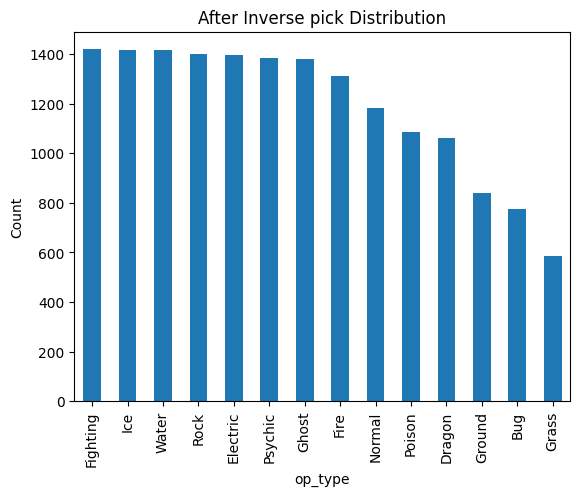

In [11]:
type_counts = inverse_pick_df["op_type1"].value_counts()
type_counts.plot(kind='bar')

# generate Inverse_pick_distribution
plt.title('After Inverse pick Distribution')
plt.xlabel('op_type')
plt.ylabel('Count')

plt.show()

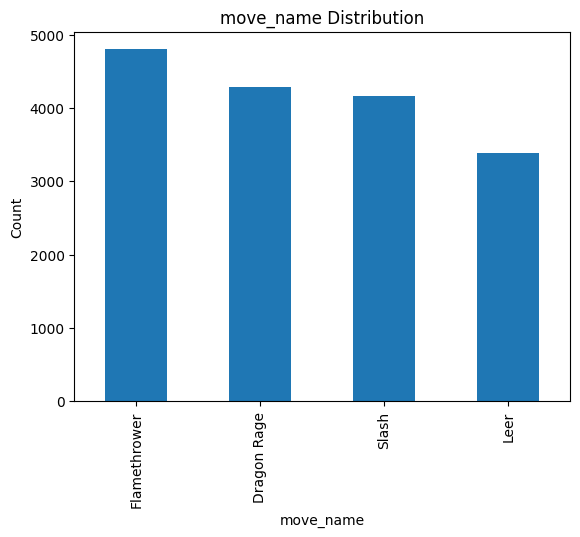

In [12]:
# move_c
move_counts = inverse_pick_df['move_name'].value_counts()

# generate move_name_distribution
move_counts.plot(kind='bar')

plt.title('move_name Distribution')
plt.xlabel('move_name')
plt.ylabel('Count')

plt.show()

In [13]:
type_to_index = {"Grass" : 0,
                 'Bug':1,
                 'Ground':2,
                 'Poison':3,
                 'Dragon':4,
                 'Normal':5,
                 'Fire':6,
                 'Rock':7,
                 'Ice':8,
                 'Fighting':9,
                 'Water':10,
                 'Ghost':11,
                 'Electric':12,
                 'Psychic':13}

move_to_index =  {"Dragon Rage" : 0,"Slash" : 1,"Leer" : 2,"Flamethrower" : 3}
index_to_move ={0 : "Leer",1 : "Dragon Rage", 2 : "Slash", 3 : "Flamethrower"}

## Start to train Decision Tree

In [14]:
# X: characteristic data，include hp, move_remain for each move,enemy_hp,enemy_type_index, etc.
# X: ["my_hp", "op_hp", "op_type1", "my_status", "op_status", "my_speed", "op_speed"]
# enemy_type_index = ["wind", "fire", "electric", ...].index(enemy_type)
# y: the choice of move

In [15]:
X = inverse_pick_df[["my_hp", "op_hp", "op_type1", "my_status", "op_status"]]

In [16]:
# replace type to index
for i, t in enumerate(X["op_type1"].unique()):
    X.replace({'op_type1': {f'{t}': type_to_index[t]}}, inplace=True)
    
temp_X = []
for i in range(len(X)):
    temp_X.append([float(x) for x in X.iloc[i, :].to_list()])
X = temp_X
X[:3]

[[138.0, 120.0, 0.0, 0.0, 0.0],
 [135.0, 37.0, 0.0, 0.0, 0.0],
 [138.0, 125.0, 0.0, 0.0, 0.0]]

In [17]:
y = inverse_pick_df[["move_name"]]

In [18]:
for i, move in enumerate(inverse_pick_df["move_name"].unique()):
    y.replace({'move_name': {f'{move}': move_to_index[move]}}, inplace=True)

temp_y = []
for i in range(len(y)):
    temp_y.append(int(y.iloc[i, :]))
y = temp_y
y[:3]

[2, 3, 1]

In [19]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [20]:
clf = DecisionTreeClassifier(max_depth=5)

# train
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

## Test

In [21]:
# prediction
new_situation = np.array([[132.0, 25.0, 13.0, 0.0, 0.0]])  # input characteristic data
predicted_move = clf.predict(new_situation)
print(f"Predicted move: {index_to_move[predicted_move[0]]}")

Predicted move: Dragon Rage


## Plot

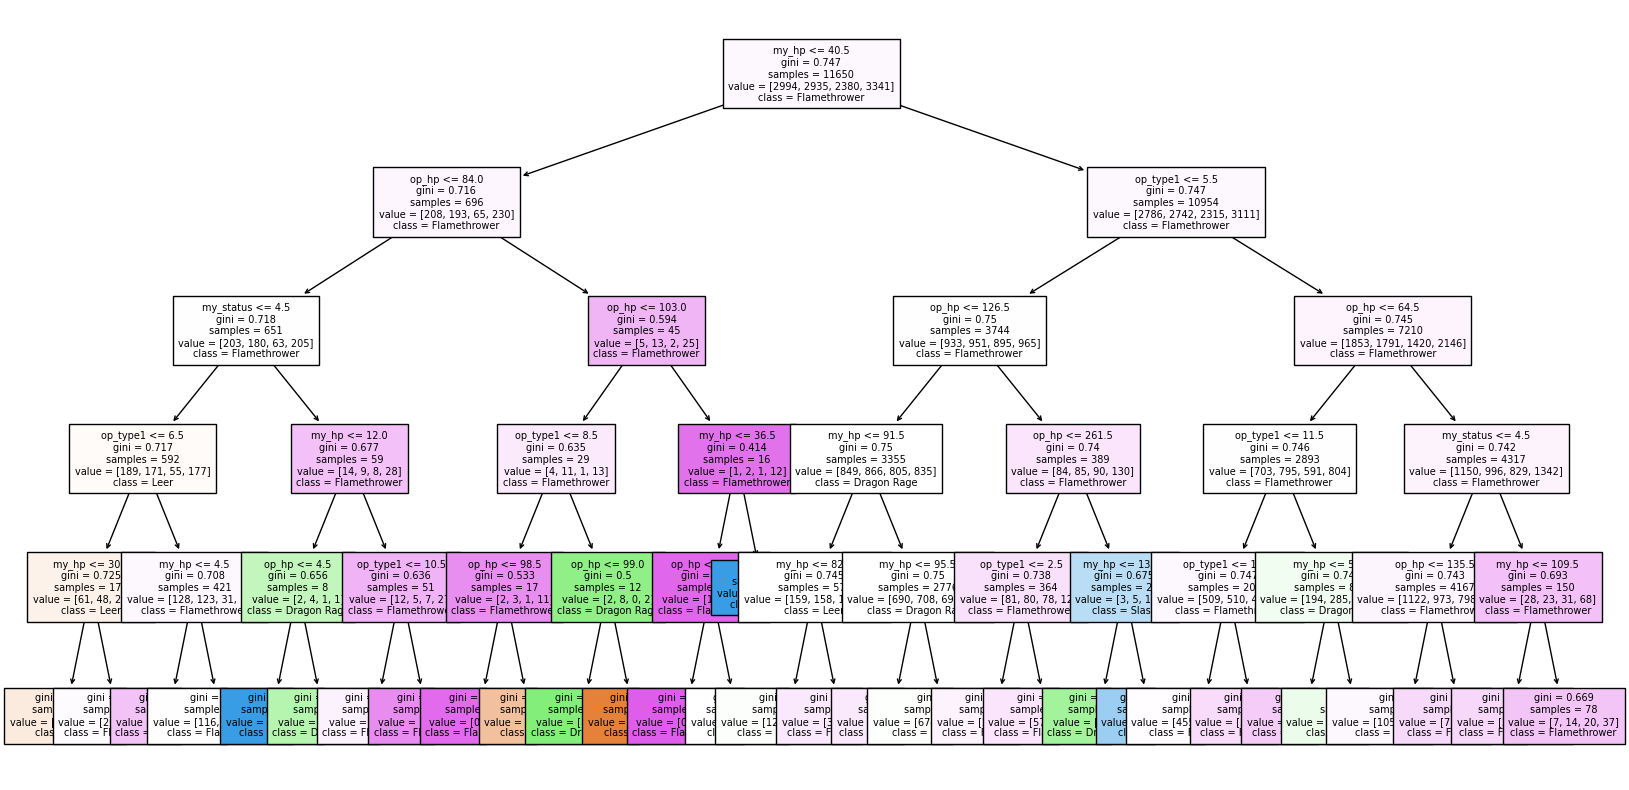

In [22]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# plot
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf, filled=True, fontsize=7, feature_names=["my_hp", "op_hp", "op_type1", "my_status", "op_status"], \
          class_names=["Leer", "Dragon Rage", "Slash", "Flamethrower"])
plt.show()

In [23]:
fig.savefig('./models/pokemon_decision_tree.png')

Download DT model

In [24]:
# import joblib

In [25]:
# # store model
# joblib.dump(clf, './models/pokemon_decision_tree_d5.pkl')

In [26]:
# # prediction by loaded model
# new_battle = [25.0, 25.0, 13.0, 0.0, 0.0, 5005.0, 3355.0]
# predicted_move = loaded_clf.predict([new_battle])
# move_trans ={0 : "Leer",1 : "Dragon Rage", 2 : "Slash", 3 : "Flamethrower"}

# print(f"Predicted move: {move_trans[predicted_move[0]]}")

## Plot overall win_rate for different model

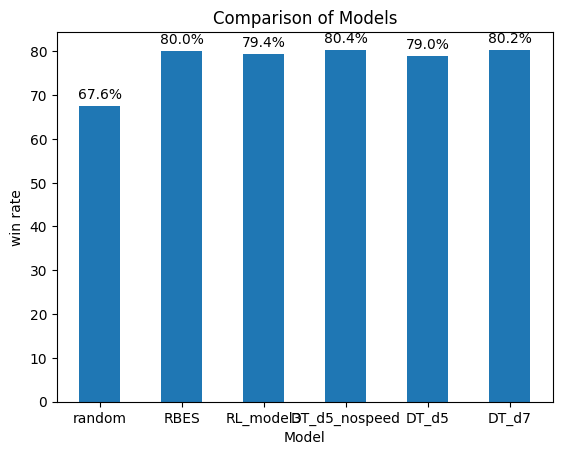

In [27]:
x = ["random", "RBES", "RL_model3", "DT_d5_nospeed", "DT_d5", "DT_d7"]
y = np.array([67.6, 80.0, 79.4, 80.4, 79.0, 80.2])
plt.bar(x, y, width=0.5)

plt.title('Comparison of Models')
plt.xlabel('Model')
plt.ylabel('win rate')
for i in range(len(x)):
    plt.text(i, y[i]+1, str(y[i])+"%", ha='center', va='bottom')

plt.show()